In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import efficientnet as efn
from common.model_utils import input_size
from sklearn import metrics
import pandas as pd
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Function to load TFLite model
def load_tflite_model(model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    return interpreter


# Function to preprocess image
def preprocess_image(image_path, img_size):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_size, img_size)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [3]:
data_folder = "/Users/dion/Github/Y4_Projects/FYP/dev/Training Data"
landmark_data_folder = "/Users/dion/Github/Y4_Projects/FYP/dev/Training Landmarks Data"
result_folder = "/Users/dion/Github/Y4_Projects/FYP/dev/Result"
landmark_result_folder = "/Users/dion/Github/Y4_Projects/FYP/dev/Landmark Result"
models_folder = "/Users/dion/Github/Y4_Projects/FYP/dev/Benchmark Models"
landmark_models_folder = "/Users/dion/Github/Y4_Projects/FYP/dev/Landmark Models"
tuning_folder = "/Users/dion/Github/Y4_Projects/FYP/dev/Tuning"
landmark_tuning_folder = "/Users/dion/Github/Y4_Projects/FYP/dev/Landmark Tuning"

# model_type = "LandmarkB0"
# model_path = f"/Users/dion/Github/Y4_Projects/FYP/dev/Tuned Models/tflite/optimized/{model_type}.tflite"

# LANDMARK = True

Testing Base-B0


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Found 42562 images belonging to 2 classes.
Model Accuracy: 0.9721817583760162
Model Precision: 0.9562729873314262
Model Recall: 0.9896151496640195
AUC: 0.9721817583760162
Average Inference Time per Image: 0.01739240278623409 seconds
Testing Base-B1
Found 42562 images belonging to 2 classes.
Model Accuracy: 0.9710539918236925
Model Precision: 0.954811487682047
Model Recall: 0.9889102955688173
AUC: 0.9710539918236925
Average Inference Time per Image: 0.027132881264126194 seconds
Testing FLDD-B0
Found 42144 images belonging to 2 classes.
Model Accuracy: 0.9603502277904328
Model Precision: 0.9385596093855961
Model Recall: 0.9851936218678815
AUC: 0.9603502277904328
Average Inference Time per Image: 0.014232916662705696 seconds
Testing FLDD-B1
Found 42144 images belonging to 2 classes.
Model Accuracy: 0.9676347760060744
Model Precision: 0.9634123401053424
Model Recall: 0.9721905846621108
AUC: 0.9676347760060744
Average Inference Time per Image: 0.023619420266368665 seconds


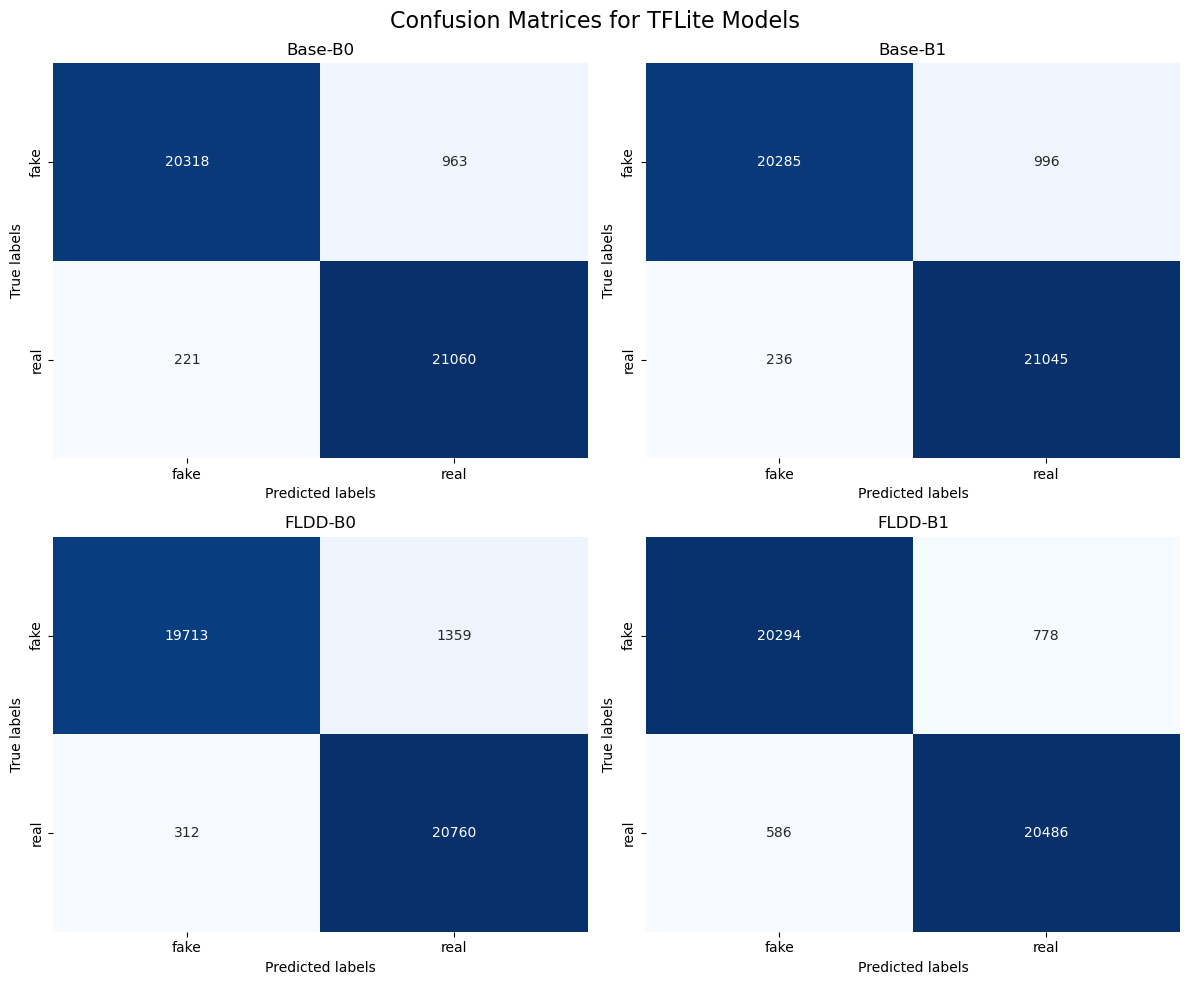

In [4]:
# Define directories and model names
model_dir = "/Users/dion/Github/Y4_Projects/FYP/dev/Tuned Models/tflite/optimized"
model_names = [
    "Base-B0",
    "Base-B1",
    "FLDD-B0",
    "FLDD-B1",
]

# Create an empty list to store the confusion matrices
confusion_matrices = []

# Iterate through each model
for model_name in model_names:
    # Set directories based on model name
    if model_name[0] == "B":
        LANDMARK = False
        tuning_dir = tuning_folder
        data_dir = data_folder
        result_dir = result_folder
    else:
        LANDMARK = True
        tuning_dir = landmark_tuning_folder
        data_dir = landmark_data_folder
        result_dir = landmark_result_folder

    # Define paths
    model_path = os.path.join(model_dir, f"{model_name}.tflite")
    test_path = os.path.join(".", data_dir, "Test")
    print(f"Testing {model_name}")

    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test the model
    test_img_gen = ImageDataGenerator(preprocessing_function=None)
    img_size = (input_details[0]["shape"][1], input_details[0]["shape"][2])
    test_generator = test_img_gen.flow_from_directory(
        directory=test_path,
        target_size=img_size,
        batch_size=1,
        class_mode=None,
        shuffle=False,
        seed=123,
    )

    # Perform inference and evaluate model
    predicted_class_indices = []
    inference_times = []
    for i in range(len(test_generator)):
        image_batch = test_generator.next()
        inference_start_time = time.time()
        interpreter.set_tensor(input_details[0]["index"], image_batch)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]["index"])
        predicted_class_indices.extend(np.argmax(output_data, axis=1))
        inference_end_time = time.time()
        inference_time = inference_end_time - inference_start_time
        inference_times.append(inference_time)

    # Get ground truth labels
    y = test_generator.classes

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y, predicted_class_indices)
    confusion_matrices.append(cm)

    # Calculate evaluation metrics
    accuracy = metrics.accuracy_score(y, predicted_class_indices)
    precision = metrics.precision_score(y, predicted_class_indices, average="binary")
    recall = metrics.recall_score(y, predicted_class_indices, average="binary")
    auc = metrics.roc_auc_score(y, predicted_class_indices)
    average_inference_time = sum(inference_times) / len(inference_times)

    print("Model Accuracy:", accuracy)
    print("Model Precision:", precision)
    print("Model Recall:", recall)
    print("AUC:", auc)
    print("Average Inference Time per Image:", average_inference_time, "seconds")

# Plot confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
plt.suptitle("Confusion Matrices for TFLite Models", fontsize=16)
for idx, (cm, model_name) in enumerate(zip(confusion_matrices, model_names)):
    ax = axes[idx // 2, idx % 2]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax,
        xticklabels=["fake", "real"],
        yticklabels=["fake", "real"],
    )
    ax.set_title(f"{model_name}")
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")

plt.tight_layout()
plt.show()